In [5]:
import json
import pprint
import matplotlib.pyplot as plt
import math
import statistics
import os
import copy
import random

In [196]:
class DataExplorer():
    def __init__(self, organism_name, t=0.3):
        self.organism_name = organism_name
        
        # find protein links and protein info
        self.data_dir = "new-data"
        self.data_files = os.listdir(self.data_dir + "/{}/".format(organism_name))
        
        for file in self.data_files:
            if "protein" in file and "links" in file:
                self.links_file = self.data_dir + "/{}/".format(organism_name) + file
                
        for file in self.data_files:
            if "protein" in file and "info" in file:
                self.info_file = self.data_dir + "/{}/".format(organism_name) + file
        
        for file in self.data_files:
            if "cluster" in file and "protein" in file:
                self.cluster_links_file = self.data_dir + "/{}/".format(organism_name) + file
        
        for file in self.data_files:
            if "cluster" in file and "info" in file:
                self.cluster_desc_file = self.data_dir + "/{}/".format(organism_name) + file
        
        for file in self.data_files:
            if "protein" in file and "sequences" in file:
                self.seq_file = self.data_dir + "/{}/".format(organism_name) + file
        
        #self.filtered_names_set, self.filtered_names_list, self.unfiltered_names = (
        #    self.filter_protein_names(self.make_protein_names()))  
        self.adj_list = self.make_adj_list(self.make_protein_links(), t)
        self.filtered_names_set, self.filtered_names_list = (
            self.filter_protein_names(self.adj_list))
        
#         self.cluster_sizes = self.make_cluster_sizes()
#         self.clusters_sorted = self.sort_clusters()
#         self.annotation_list = self.make_annotation_list()
#         self.cluster_size_mean = self.get_mean()
#         self.cluster_size_std_dev = self.get_std_dev()
#         self.sequences = self.make_sequence_list()
        
    def make_protein_links(self):
        with open(self.links_file) as file:
            lines = []
            for line in file:
                lines.append(line.split())
            protein_links = lines
        file.close()
        
        return protein_links[1:]
    
    def make_protein_names(self):
        with open(self.info_file) as file:
            lines = []
            for line in file:
                lines.append(line.split()[0:2])
            protein_names = lines
        file.close()
        
        return protein_names[1:]
    
    def filter_protein_names(self, protein_names):
        protein_names_filtered_set = set()
        protein_names_filtered_list = []
        protein_names_unfiltered = {}

        for name in protein_names:
            #protein_id, pref_name = name
            #protein_names_unfiltered[protein_id] = pref_name
            protein_names_filtered_set.add(name)
            protein_names_filtered_list.append(name)
            # prefix = protein_id[int(protein_id.index(".")) + 1 : int(protein_id.index("_"))]

#             if not pref_name.startswith(prefix):
#                 protein_names_filtered[protein_id] = pref_name
        return protein_names_filtered_set, protein_names_filtered_list
    
    def make_adj_list(self, protein_links, t):
        protein_links_dict = {}

        for link in protein_links:
            protein_1, protein_2, score = link
            
            if (int(score) / 1000) < t:
                if protein_1 not in protein_links_dict: 
                    protein_links_dict[protein_1] = []
            else:
                if protein_1 not in protein_links_dict: 
                    protein_links_dict[protein_1] = [(protein_2, round(int(score) / 1000, 7))]
                else:
                    protein_links_dict[protein_1].append((protein_2, round(int(score) / 1000, 7)))
        
        cpy = copy.deepcopy(protein_links_dict)
        for protein in cpy:
            if len(protein_links_dict[protein]) == 0:
                del protein_links_dict[protein]
        
        return protein_links_dict
    
    def make_annotation_list(self):
        with open(self.cluster_links_file) as file:
            lines = []
            for line in file:
                lines.append(line.split()[1:3])
            protein_clusters = lines
        file.close()
        
        protein_clusters_dict = {}
        
        for (cluster_id, protein_id) in protein_clusters[1:]:
            cluster_id_clean = cluster_id[cluster_id.index(":") + 1:]
            
            if protein_id not in protein_clusters_dict:
                protein_clusters_dict[protein_id] = [cluster_id_clean]
            else:
                protein_clusters_dict[protein_id].append(cluster_id_clean)
        
        for protein_id in protein_clusters_dict:
            clusters_w_sizes = zip(protein_clusters_dict[protein_id], 
                                   [self.cluster_sizes[cluster] for cluster in protein_clusters_dict[protein_id]]
                                  )
            sorted_clusters = sorted(clusters_w_sizes, key=lambda tup: tup[1])
            protein_clusters_dict[protein_id] = [p for (p, _) in sorted_clusters]
            
        return protein_clusters_dict
    
    def make_cluster_sizes(self):
        with open(self.cluster_desc_file) as file:
            lines = []
            for line in file:
                lines.append(line.split()[1:3])
            cluster_sizes = lines
        file.close()
        
        cluster_sizes_dict = {}
        
        for (cluster_id, size) in cluster_sizes[1:]:
            cluster_id_clean = cluster_id[cluster_id.index(":") + 1:]
            
            cluster_sizes_dict[cluster_id_clean] = int(size)
        
        return cluster_sizes_dict
    
    def make_sequence_list(self):
        with open(self.seq_file) as file:
            lines = {}
            protein_id = ""
            
            for line in file:
                if line.startswith(">"):
                    protein_id = line[line.index(">") + 1:].strip()
                    lines[protein_id] = ""
                else:
                    lines[protein_id] += line.strip()
        return lines
            
    
    def get_mean(self):
        size_sum = 0
        for size in self.cluster_sizes:
            size_sum += self.cluster_sizes[size]
        number_of_sizes = len(self.cluster_sizes)
        return size_sum/number_of_sizes
        
    def get_std_dev(self):
        size_sum = 0 
        for size in self.cluster_sizes:
            size_sum += (abs((self.cluster_sizes[size]-self.cluster_size_mean))**2)
        number_of_sizes = len(self.cluster_sizes)
        std_dev = math.sqrt(size_sum/number_of_sizes)
        return std_dev
    
    def sort_clusters(self):
        size_list = []
        cluster_sizes = copy.copy(self.cluster_sizes)
        for size in cluster_sizes:
            size_list.append(cluster_sizes[size])
        size_list.sort()
        size_list.reverse()
        clusters_sorted = []
        for i in range(len(size_list)):
            for j in cluster_sizes:
                if cluster_sizes[j] == size_list[i]:
                    clusters_sorted.append(j)
                    del cluster_sizes[j]
                    break
        return clusters_sorted 

In [191]:
def make_plot(obj):
    #f, ax1 = plt.subplots(1, 1, figsize=(6,4))
    # plt.tight_layout()
    fig, ax = plt.subplots()
    
    #ilovephillip = plt.imread("compeau2.png")
    #ax1.imshow(ilovephillip, extent=[1200,1600,600,900])
    
    # calculate average degree
    node_degrees = [len(obj.adj_list[i]) for i in obj.adj_list]
    degree_mean = sum(node_degrees) / len(node_degrees)
    
    # calculate graph density
    max_edges = int(len(obj.adj_list) * (len(obj.adj_list) - 1) / 2)
    number_edges = int(sum(node_degrees) / 2) # woah handshake lemma
    
    # calculate number of proteins
    n_proteins = len(obj.adj_list)
    
    # calculate avg degree / number proteins
    degree_ratio = degree_mean / n_proteins
    
    # calculate average score
    scores = []
    
    for prot in obj.adj_list:
        for interaction in obj.adj_list[prot]:
            scores.append(interaction[1])
    
    score_mean = sum(scores) / (2 * number_edges)
    
    n_bins = int(1 + 3.22 * math.log(len(node_degrees)))
    
    p = plt.hist(node_degrees, bins = n_bins, color="#575fcf", edgecolor="#3c40c6", alpha=0.8)
    # p.set_transform(ax.transAxes)
    # p.set_clip_on(False)

    plt.title("PPI Network Degree Histogram ({})".format(obj.organism_name))
    plt.xlabel("Node degrees")
    plt.ylabel("Frequency")
    
    font = {
        'size': 14,
    }
    
    ax.text(0.4,0.65, "# Nodes: {}\nAverage degree: {}\nDensity ([0,1]): {}"
             .format(str(n_proteins), str(round(degree_mean, 3)), str(round(number_edges / max_edges, 3))),
             bbox=dict(facecolor='#d2dae2', alpha=0.2), fontdict=font, transform=ax.transAxes)
    
    # ax2.set_title("PPI Network Statistics")
#     ax2.axis('tight')
#     ax2.axis('off')
#     table = ax2.table(cellText = [
#                           [n_proteins],
#                           [round(degree_mean, 3)],
#                           [round(number_edges / max_edges, 3)]],
#               rowLabels=["# Nodes", "Average degree", "Density ([0, 1])"], 
#               loc="upper center", cellLoc='center', edges='open', colWidths=[0.3, 1])

#     table.auto_set_font_size(False)
#     table.set_fontsize(14)
    
    plt.savefig("{}-ppi-histogram.jpg".format(obj.organism_name))

In [198]:
def plot_datasets():
    subfolders = [f for f in os.scandir("new-data") if f.is_dir()]
    
    for orgsm in subfolders:
        orgsm_name = orgsm.name
        orgsm_explorer = DataExplorer(orgsm_name)
        
        make_plot(orgsm_explorer)

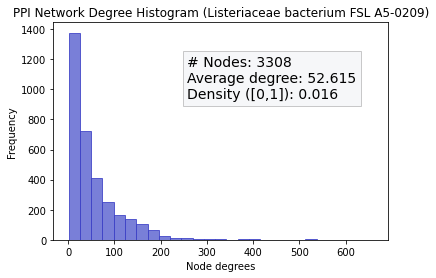

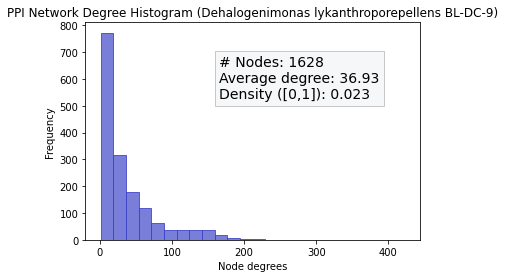

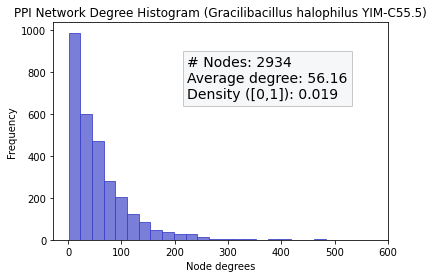

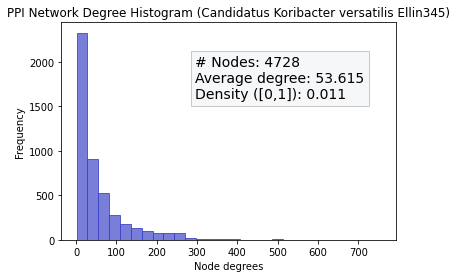

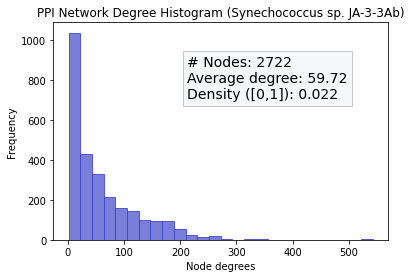

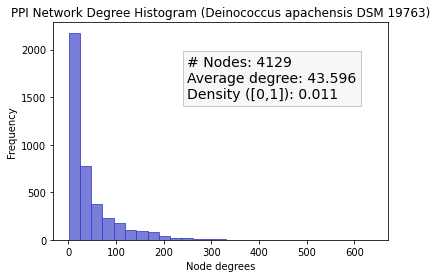

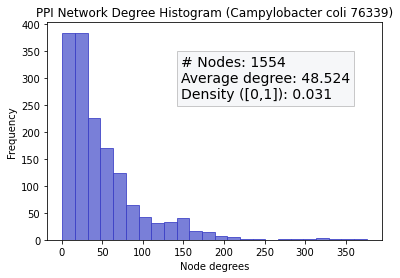

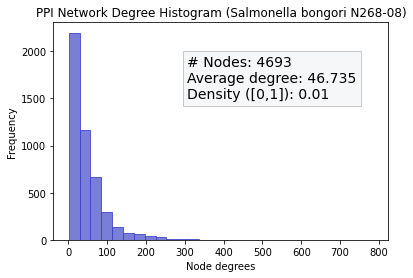

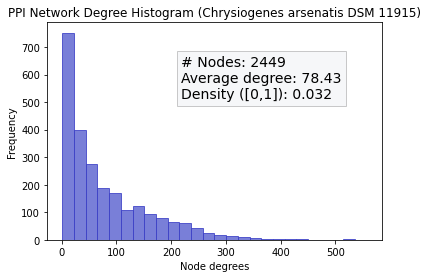

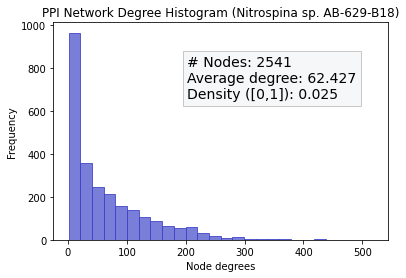

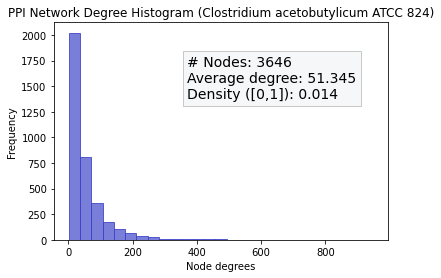

In [199]:
plot_datasets()